# DLV Group Project

In [11]:
 # General imports
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, datetime
# Shortcuts to keras if (however from tensorflow)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 

# Shortcut for displaying images
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
df = pd.read_json("/content/InfraredSolarModules/module_metadata.json",orient="index")
df

,image_filepath,anomaly_class
13357,images/13357.jpg,No-Anomaly
13356,images/13356.jpg,No-Anomaly
19719,images/19719.jpg,No-Anomaly
11542,images/11542.jpg,No-Anomaly
11543,images/11543.jpg,No-Anomaly
...,...,...
8488,images/8488.jpg,Vegetation
8489,images/8489.jpg,Vegetation
7464,images/7464.jpg,Cracking
18065,images/18065.jpg,No-Anomaly


In [13]:
df['image_name'] = df['image_filepath'].str[7:]
df

,image_filepath,anomaly_class,image_name
13357,images/13357.jpg,No-Anomaly,13357.jpg
13356,images/13356.jpg,No-Anomaly,13356.jpg
19719,images/19719.jpg,No-Anomaly,19719.jpg
11542,images/11542.jpg,No-Anomaly,11542.jpg
11543,images/11543.jpg,No-Anomaly,11543.jpg
...,...,...,...
8488,images/8488.jpg,Vegetation,8488.jpg
8489,images/8489.jpg,Vegetation,8489.jpg
7464,images/7464.jpg,Cracking,7464.jpg
18065,images/18065.jpg,No-Anomaly,18065.jpg


In [14]:
reduced_df=df.sample(frac=0.3,random_state=200) # random state is a seed value
train_df=reduced_df.sample(frac=0.8,random_state=200) # random state is a seed value
validation_test_df=reduced_df.drop(train_df.index)
validation_df=validation_test_df.sample(frac=0.5,random_state=200)
test_df=validation_test_df.drop(validation_df.index)
print(train_df.info())
print(validation_df.info())
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 16053 to 12678
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  4800 non-null   object
 1   anomaly_class   4800 non-null   object
 2   image_name      4800 non-null   object
dtypes: object(3)
memory usage: 150.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 17411 to 9377
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  600 non-null    object
 1   anomaly_class   600 non-null    object
 2   image_name      600 non-null    object
dtypes: object(3)
memory usage: 18.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 18000 to 8506
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  600 non-null    object
 1   a

In [18]:
batch_size = 64
image_height = 40
image_width = 24
num_train_images = 4800
num_valid_images = 600
num_classes = 12

model_1 = Sequential()
model_1.add(Conv2D(32, (3, 3), input_shape=(image_height, image_width, 1)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(32, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

model_1.add(Conv2D(64, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_1.add(Flatten())  
model_1.add(Dense(64))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))



model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-3),
              metrics=['accuracy'])
model_1.summary()

#model_1.compile(loss='categorical_crossentropy',
 #             optimizer='adam',
  #            metrics=['accuracy'])
#model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 38, 22, 32)        320       
                                                                 
 activation_10 (Activation)  (None, 38, 22, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 19, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 9, 32)         9248      
                                                                 
 activation_11 (Activation)  (None, 17, 9, 32)         0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 4, 32)         0         
 2D)                                                  

In [19]:
batch_size = 64
datagen_train=ImageDataGenerator(rescale=1./255)
datagen_validation=ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "grayscale"
)

validation_generator = datagen_train.flow_from_dataframe(
    dataframe = validation_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
     color_mode = "grayscale"
)

Found 4800 validated image filenames belonging to 12 classes.
Found 600 validated image filenames belonging to 12 classes.


In [20]:
history = model_1.fit(
    train_generator,
    epochs = 100,
    validation_data = validation_generator
 )

Epoch 1/100
75/75 [==============================] - 2s 19ms/step - loss: 1.9540 - accuracy: 0.4950 - val_loss: 1.7783 - val_accuracy: 0.5083
Epoch 2/100
75/75 [==============================] - 1s 17ms/step - loss: 1.8705 - accuracy: 0.5048 - val_loss: 1.7508 - val_accuracy: 0.5083
Epoch 3/100
75/75 [==============================] - 1s 17ms/step - loss: 1.8189 - accuracy: 0.5050 - val_loss: 1.7184 - val_accuracy: 0.5083
Epoch 4/100
75/75 [==============================] - 1s 17ms/step - loss: 1.8059 - accuracy: 0.5050 - val_loss: 1.7164 - val_accuracy: 0.5083
Epoch 5/100
75/75 [==============================] - 1s 17ms/step - loss: 1.7980 - accuracy: 0.5050 - val_loss: 1.7635 - val_accuracy: 0.5083
Epoch 6/100
75/75 [==============================] - 1s 18ms/step - loss: 1.7959 - accuracy: 0.5050 - val_loss: 1.7147 - val_accuracy: 0.5083
Epoch 7/100
75/75 [==============================] - 1s 17ms/step - loss: 1.7813 - accuracy: 0.5050 - val_loss: 1.7182 - val_accuracy: 0.5083
Epoch 

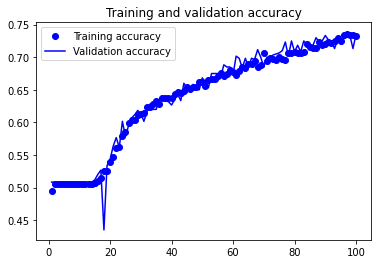

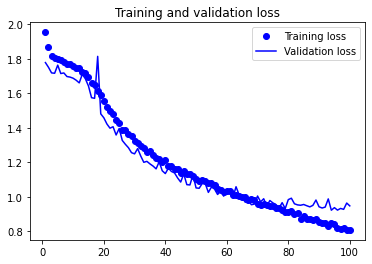

In [22]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [27]:
model_1.evaluate(validation_generator)

10/10 [==============================] - 0s 35ms/step - loss: 0.9481 - accuracy: 0.7350


[0.9480855464935303, 0.7350000143051147]

# Add Data Agumentation

In [23]:
batch_size = 64
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
datagen_validation=ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    dataframe = train_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
    color_mode = "grayscale"
)

validation_generator = datagen_train.flow_from_dataframe(
    dataframe = validation_df,
    directory = "/content/InfraredSolarModules/images/",
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    batch_size = batch_size,
     color_mode = "grayscale"
)

Found 4800 validated image filenames belonging to 12 classes.
Found 600 validated image filenames belonging to 12 classes.


In [25]:
batch_size = 64
image_height = 40
image_width = 24
num_train_images = 4800
num_valid_images = 600
num_classes = 12

model_2 = Sequential()
model_2.add(Conv2D(32, (3, 3), input_shape=(image_height, image_width, 1)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_2.add(Flatten())  
model_2.add(Dense(64))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))



model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-3),
              metrics=['accuracy'])
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 38, 22, 32)        320       
                                                                 
 activation_20 (Activation)  (None, 38, 22, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 19, 11, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 17, 9, 32)         9248      
                                                                 
 activation_21 (Activation)  (None, 17, 9, 32)         0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 4, 32)         0         
 g2D)                                                 

In [26]:
history = model_2.fit(
    train_generator,
    epochs = 100,
    validation_data = validation_generator
 )

Epoch 1/100
75/75 [==============================] - 54s 19ms/step - loss: 1.9769 - accuracy: 0.4954 - val_loss: 1.7929 - val_accuracy: 0.5083
Epoch 2/100
75/75 [==============================] - 1s 17ms/step - loss: 1.8751 - accuracy: 0.5050 - val_loss: 1.7577 - val_accuracy: 0.5083
Epoch 3/100
75/75 [==============================] - 2s 21ms/step - loss: 1.8112 - accuracy: 0.5050 - val_loss: 1.7209 - val_accuracy: 0.5083
Epoch 4/100
75/75 [==============================] - 1s 17ms/step - loss: 1.8060 - accuracy: 0.5050 - val_loss: 1.7263 - val_accuracy: 0.5083
Epoch 5/100
75/75 [==============================] - 1s 17ms/step - loss: 1.8001 - accuracy: 0.5050 - val_loss: 1.7413 - val_accuracy: 0.5083
Epoch 6/100
75/75 [==============================] - 1s 18ms/step - loss: 1.7862 - accuracy: 0.5050 - val_loss: 1.7353 - val_accuracy: 0.5083
Epoch 7/100
75/75 [==============================] - 1s 17ms/step - loss: 1.7763 - accuracy: 0.5050 - val_loss: 1.7003 - val_accuracy: 0.5083
Epoch

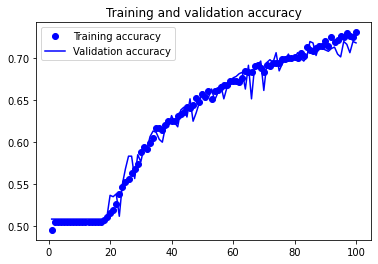

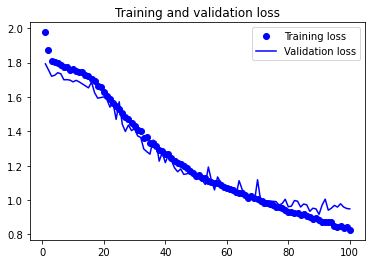

In [28]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy") 
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [29]:
model_2.evaluate(validation_generator)

10/10 [==============================] - 0s 13ms/step - loss: 0.9490 - accuracy: 0.7183


[0.9490442872047424, 0.7183333039283752]